# StatsBomb xG model

Every shot recorded in the StatsBomb Database has a Freeze Frame attached to it, revealing the location of all players, attacking or defending, within the camera frame, as well as the goalkeeper’s position. This additional information allows training more accurate expected goals model.

In [1]:
import os; import sys
from tqdm import tqdm

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2

from socceraction import spadl

We'll use dask to speed things up a bit.

In [3]:
import dask
dask.config.set({'dataframe.convert-string': False})
dask.config.set({'temporary_directory': '/tmp'})

cluster = False
#cluster = '134.58.41.90:8786'

if not cluster:
    from dask.distributed import Client
    client = Client(n_workers=4, threads_per_worker=4) 
else:
    from dask.distributed import Client
    client = Client(cluster)

client

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/socceraction/.venv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38905 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38905/status,
Dashboard: http://127.0.0.1:38905/status,Workers: 4
Total threads: 16,Total memory: 31.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40289,Workers: 4
Dashboard: http://127.0.0.1:38905/status,Total threads: 16
Started: Just now,Total memory: 31.25 GiB
Comm: tcp://127.0.0.1:42259,Total threads: 4
Dashboard: http://127.0.0.1:42589/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:35257,


## Load dataset
We will use our dataset with StatsBomb events of the Big 5 leagues in 2015/16. The `1.1-load-statsbomb-data` notebook explains how to create this dataset.

In [4]:
from pathlib import Path
from socceraction.data import HDFDataset, PartitionIdentifier

data_dir = Path("../../data")

# Open a HDF dataset
dataset = HDFDataset(
    path=(data_dir / "statsbomb-bigfive-1516.h5"), 
    mode="r"
)

In [5]:
train_partitions = [
    PartitionIdentifier(competition_id=2,  season_id=27),  # ENG 2015/16
    PartitionIdentifier(competition_id=7,  season_id=27),  # FRA 2015/16
    PartitionIdentifier(competition_id=9,  season_id=27),  # GER 2015/16
    PartitionIdentifier(competition_id=11, season_id=27),  # ESP 2015/16
]
test_partitions = [
    PartitionIdentifier(competition_id=12, season_id=27),  # ITA 2015/16
]

## Features and labels

Next, we have to compute the features and labels for training the model. Let's start with a single game before we compute them for the full dataset.

In [6]:
game = dataset.games().set_index("game_id").loc[3754245]
events = dataset.read_table("events", partitions=[PartitionIdentifier(game_id=3754245)])
actions = dataset.read_table("actions", partitions=[PartitionIdentifier(game_id=3754245)])

In [7]:
from socceraction.xg import create_shot_mask

# We'll only use shots from open-play, excluding own-goals
mask_fn = create_shot_mask({"shot"}, exclude_owngoals=True)

In [8]:
import socceraction.features as fs
from socceraction.xg.labels import goal_from_shot
from socceraction.data.transforms import ActionsToFeatures, StatsBombEventsToFeatures

actions_based_features = [
    fs.actiontype,
    fs.shot_dist,
    fs.shot_location,
    fs.shot_visible_angle,
    fs.bodypart_onehot,
    fs.rebound,
    goal_from_shot,  # the label
]

events_based_features = [
    fs.statsbomb_open_goal,
    fs.statsbomb_first_touch,
    fs.statsbomb_free_projection,
    fs.statsbomb_goalkeeper_position,
    fs.statsbomb_defenders_position,
    fs.statsbomb_assist,
    fs.statsbomb_counterattack,
    fs.statsbomb_shot_impact_height
]

class ToFeatures:
    """A custom feature generator that combines features derived from the event and action representations."""
    def __init__(self, action_features, event_features):
        self.actions_to_features = ActionsToFeatures(xfns=action_features, mask_fn=mask_fn)
        self.events_to_features = StatsBombEventsToFeatures(xfns=event_features)
        
    def __call__(self, game, inputs):
        events, actions = inputs
        return (
            self.actions_to_features(game, actions)
            .merge(self.events_to_features(game, events), on="original_event_id", how="left")
        )

to_features = ToFeatures(actions_based_features, events_based_features)

df_features = to_features(game, (events, actions,)).set_index(["game_id", "action_id", "original_event_id"])
df_features.head()

actiontype  \
game_id action_id original_event_id                                 
3754245 199       9df6670f-397b-46f1-ae04-5284d61ecdad       shot   
        203       8841291a-3cf9-4b83-9f1e-8249f5e2c3ce       shot   
        206       d3772dd6-6eea-455c-8730-2440db142ee3       shot   
        209       c713f4f8-c545-4b26-aa5d-89ac6cc98c79       shot   
        376       c3b2a35a-9173-42ad-a9a9-612fe86a336c       shot   

                                                        bodypart_foot  \
game_id action_id original_event_id                                     
3754245 199       9df6670f-397b-46f1-ae04-5284d61ecdad           True   
        203       8841291a-3cf9-4b83-9f1e-8249f5e2c3ce           True   
        206       d3772dd6-6eea-455c-8730-2440db142ee3           True   
        209       c713f4f8-c545-4b26-aa5d-89ac6cc98c79          False   
        376       c3b2a35a-9173-42ad-a9a9-612fe86a336c           True   

                                                        bodypart_head  \
game_id action_id original_event_id                                     
3754245 199       9df6670f-397b-46f1-ae04-5284d61ecdad          False   
        203       8841291a-3cf9-4b83-9f1e-8249f5e2c3ce          False   
        206       d3772dd6-6eea-455c-8730-2440db142ee3          False   
        209       c713f4f8-c545-4b26-aa5d-89ac6cc98c79           True   
        376       c3b2a35a-9173-42ad-a9a9-612fe86a336c          False   

                                                        bodypart_head_or_other  \
game_id action_id original_event_id                                              
3754245 199       9df6670f-397b-46f1-ae04-5284d61ecdad                   False   
        203       8841291a-3cf9-4b83-9f1e-8249f5e2c3ce                   False   
        206       d3772dd6-6eea-455c-8730-2440db142ee3                   False   
        209       c713f4f8-c545-4b26-aa5d-89ac6cc98c79                    True   
        376       c3b2a35a-9173-42ad-a9a9-612fe86a336c                   False   

                                                        bodypart_other  \
game_id action_id original_event_id                                      
3754245 199       9df6670f-397b-46f1-ae04-5284d61ecdad           False   
        203       8841291a-3cf9-4b83-9f1e-8249f5e2c3ce           False   
        206       d3772dd6-6eea-455c-8730-2440db142ee3           False   
        209       c713f4f8-c545-4b26-aa5d-89ac6cc98c79           False   
        376       c3b2a35a-9173-42ad-a9a9-612fe86a336c           False   

                                                        dist_shot   dx_shot  \
game_id action_id original_event_id                                           
3754245 199       9df6670f-397b-46f1-ae04-5284d61ecdad  19.396876  19.29375   
        203       8841291a-3cf9-4b83-9f1e-8249f5e2c3ce   9.981491   6.25625   
        206       d3772dd6-6eea-455c-8730-2440db142ee3   6.726811   3.36875   
        209       c713f4f8-c545-4b26-aa5d-89ac6cc98c79   5.916897   3.45625   
        376       c3b2a35a-9173-42ad-a9a9-612fe86a336c  23.477027  16.66875   

                                                        dy_shot  \
game_id action_id original_event_id                               
3754245 199       9df6670f-397b-46f1-ae04-5284d61ecdad   1.9975   
        203       8841291a-3cf9-4b83-9f1e-8249f5e2c3ce   7.7775   
        206       d3772dd6-6eea-455c-8730-2440db142ee3   5.8225   
        209       c713f4f8-c545-4b26-aa5d-89ac6cc98c79   4.8025   
        376       c3b2a35a-9173-42ad-a9a9-612fe86a336c  16.5325   

                                                        goal_from_shot  \
game_id action_id original_event_id                                      
3754245 199       9df6670f-397b-46f1-ae04-5284d61ecdad           False   
        203       8841291a-3cf9-4b83-9f1e-8249f5e2c3ce           False   
        206       d3772dd6-6eea-455c-8730-2440db142ee3           False   
        209       c713f4f8-c545-4b26-aa5d-89ac6cc98c79     

In [9]:
df_train = dataset.transform(to_features, from_table=["events", "actions"], to_table=None, partitions=train_partitions,  engine="dask").compute()
df_train.set_index(["game_id", "action_id", "original_event_id"], inplace=True)

2024-10-28 17:19:18,872 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2024-10-28 17:19:23,853 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2024-10-28 17:19:27,440 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2024-10-28 17:19:28,905 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2024-10-28 17:19:33,424 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2024-10-28 17:19:33,623 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2024-10-28 17:19:38,995 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2024-10-28 17:19:39,256 - distributed.utils_perf - WARNING - full garbage collections took

In [10]:
df_test = dataset.transform(to_features, from_table=["events", "actions"], to_table=None, partitions=test_partitions,  engine="dask").compute()
df_test.set_index(["game_id", "action_id", "original_event_id"], inplace=True)

2024-10-28 17:20:09,936 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2024-10-28 17:20:11,200 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-10-28 17:20:11,753 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2024-10-28 17:20:14,440 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2024-10-28 17:20:14,710 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-10-28 17:20:16,009 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2024-10-28 17:20:18,670 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2024-10-28 17:20:20,125 - distributed.utils_perf - WARNING - full garbage collections took

## xG Model

In [11]:
# filter shots
open_play_shot = df_train.actiontype == 'shot'
open_play_assist = df_train.type_assist.isin(['standard_pass', 'cross', 'cut_back', 'through_ball'])
no_rebound = ~df_train.rebound
df_train = df_train.loc[open_play_shot & open_play_assist & no_rebound]

open_play_shot = df_test.actiontype == 'shot'
open_play_assist = df_test.type_assist.isin(['standard_pass', 'cross', 'cut_back', 'through_ball'])
no_rebound = ~df_test.rebound
df_test = df_test.loc[open_play_shot & open_play_assist & no_rebound]

# replace inf values
df_train.replace([np.inf], 100000, inplace=True)
df_test.replace([np.inf], 100000, inplace=True)

display(df_train.head())

actiontype  \
game_id action_id original_event_id                                 
265944  74        811d98b4-0e0d-4fe2-a1bd-06a274def6ec       shot   
        234       c8d9a887-86ca-4862-b560-130b1ef5c7fe       shot   
        256       74254798-ae64-4af4-8b4a-8dc7860b7064       shot   
        312       c155853d-1685-47ba-a755-58f8282b3873       shot   
        378       80294e2c-f5b3-404d-8442-f38e735b4749       shot   

                                                        bodypart_foot  \
game_id action_id original_event_id                                     
265944  74        811d98b4-0e0d-4fe2-a1bd-06a274def6ec          False   
        234       c8d9a887-86ca-4862-b560-130b1ef5c7fe           True   
        256       74254798-ae64-4af4-8b4a-8dc7860b7064           True   
        312       c155853d-1685-47ba-a755-58f8282b3873          False   
        378       80294e2c-f5b3-404d-8442-f38e735b4749           True   

                                                        bodypart_head  \
game_id action_id original_event_id                                     
265944  74        811d98b4-0e0d-4fe2-a1bd-06a274def6ec           True   
        234       c8d9a887-86ca-4862-b560-130b1ef5c7fe          False   
        256       74254798-ae64-4af4-8b4a-8dc7860b7064          False   
        312       c155853d-1685-47ba-a755-58f8282b3873           True   
        378       80294e2c-f5b3-404d-8442-f38e735b4749          False   

                                                        bodypart_head_or_other  \
game_id action_id original_event_id                                              
265944  74        811d98b4-0e0d-4fe2-a1bd-06a274def6ec                    True   
        234       c8d9a887-86ca-4862-b560-130b1ef5c7fe                   False   
        256       74254798-ae64-4af4-8b4a-8dc7860b7064                   False   
        312       c155853d-1685-47ba-a755-58f8282b3873                    True   
        378       80294e2c-f5b3-404d-8442-f38e735b4749                   False   

                                                        bodypart_other  \
game_id action_id original_event_id                                      
265944  74        811d98b4-0e0d-4fe2-a1bd-06a274def6ec           False   
        234       c8d9a887-86ca-4862-b560-130b1ef5c7fe           False   
        256       74254798-ae64-4af4-8b4a-8dc7860b7064           False   
        312       c155853d-1685-47ba-a755-58f8282b3873           False   
        378       80294e2c-f5b3-404d-8442-f38e735b4749           False   

                                                        dist_shot   dx_shot  \
game_id action_id original_event_id                                           
265944  74        811d98b4-0e0d-4fe2-a1bd-06a274def6ec   5.238228   4.76875   
        234       c8d9a887-86ca-4862-b560-130b1ef5c7fe  19.586948  19.03125   
        256       74254798-ae64-4af4-8b4a-8dc7860b7064   9.804956   9.58125   
        312       c155853d-1685-47ba-a755-58f8282b3873  15.310778  14.91875   
        378       80294e2c-f5b3-404d-8442-f38e735b4749  11.585149   9.75625   

                                                        dy_shot  \
game_id action_id original_event_id                               
265944  74        811d98b4-0e0d-4fe2-a1bd-06a274def6ec   2.1675   
        234       c8d9a887-86ca-4862-b560-130b1ef5c7fe   4.6325   
        256       74254798-ae64-4af4-8b4a-8dc7860b7064   2.0825   
        312       c155853d-1685-47ba-a755-58f8282b3873   3.4425   
        378       80294e2c-f5b3-404d-8442-f38e735b4749   6.2475   

                                                        goal_from_shot  \
game_id action_id original_event_id                                      
265944  74        811d98b4-0e0d-4fe2-a1bd-06a274def6ec           False   
        234       c8d9a887-86ca-4862-b560-130b1ef5c7fe           False   
        256       74254798-ae64-4af4-8b4a-8dc7860b7064           False   
        312       c155853d-1685-47ba-a755-58f8282b3873     

In [12]:
NUM = [
 'dist_shot',
 'dx_shot',
 'dy_shot',
 'visible_angle_shot',
 'bodypart_head_or_other',
 'first_touch',
 'free_projection_pct',
 'goalkeeper_x',
 'goalkeeper_y',
 'dist_to_defender',
 'under_pressure',
 'nb_defenders_in_shot_line',
 'one_on_one',
 'carry_dist',
 'from_counterattack',
] # numerical features
CAT = [
 'type_assist',
 'impact_height'
]  # categorical features

In [13]:
from socceraction.ml.preprocessing import simple_proc_for_tree_algorithms

from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier

preprocess_pipeline = simple_proc_for_tree_algorithms(
    numeric_features=NUM,
    categoric_features=CAT
)
# xgboost classification model
base_model = XGBClassifier(enable_categorical=True, n_estimators=50, max_depth=3)
# create pipeline
pipe = make_pipeline(preprocess_pipeline, base_model)

In [14]:
from socceraction.xg import XGModel

model = XGModel(
    dataset_transformer=to_features,
    pipeline=pipe
)

In [15]:
model.train(df_train)

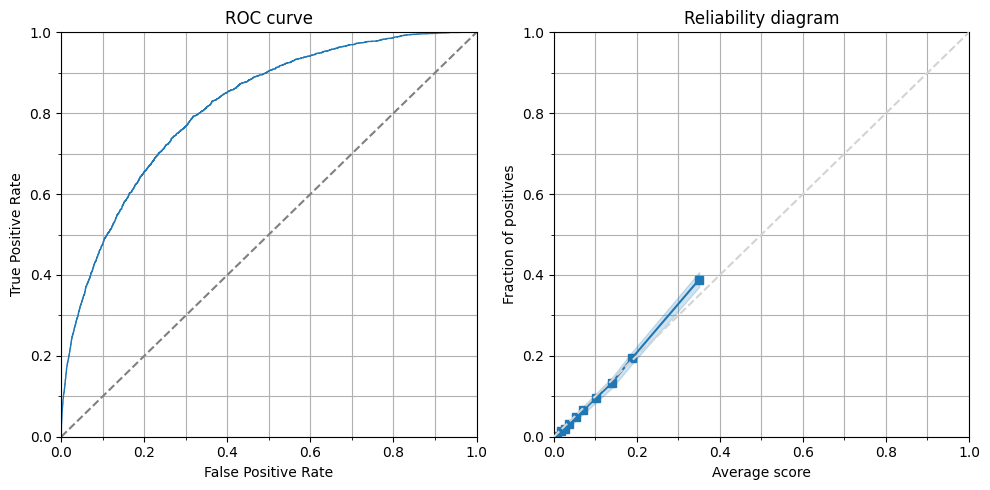

Brier score: 0.0749
AUROC: 0.8151


In [16]:
metrics = model.validate(df_train, plot=True)
print(f"Brier score: {metrics['brier']:.4f}")
print(f"AUROC: {metrics['roc']:.4f}")

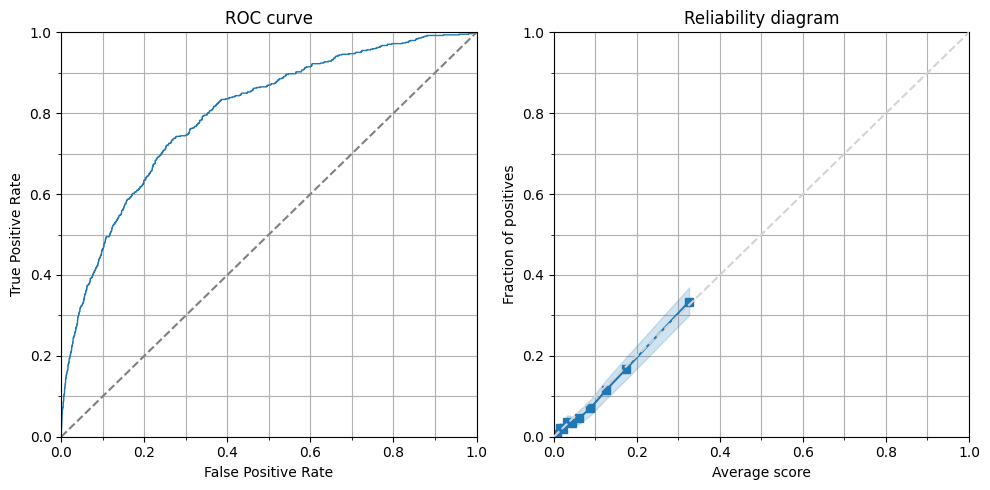

Brier score: 0.0672
AUROC: 0.7979


In [17]:
metrics = model.validate(df_test, plot=True)
print(f"Brier score: {metrics['brier']:.4f}")
print(f"AUROC: {metrics['roc']:.4f}")

In [18]:
dataset.close()